In [26]:
import numpy as np
import matplotlib.pyplot as plt

### Algorithm

Steps to implement Soft K-Means:

1. Initialize m1, m2,...mk = random points in X
2. While not converged:

    Step 1: Calculate cluster responsiblities
    
$$ r_k^n= \frac{\exp[-\beta d(m_k, x^n]}{\sum_j \exp[-\beta d(m_j, x^n]}  $$

    Step 2: Recalculate means
    
$$ m_k = \frac{\sum_n r_k^n x^n}{\sum_n r_k^n} $$

<b>Note</b> Here, convergence is checked by taking the <u>absolute</u> difference between the costs(heterogeneity) between the current and previous iteration and if it less than a tolerance value (10e-5), we stop.

In [27]:
# This is the original code, this function is used when you are doing calculation for each cell.
# dist_calculation (next cell) function is better function and is used. This function I have retained 
# just in case you run the code which uses this function.

def dist(u,v):
    diff = u - v
    return diff.dot(diff)  

# Sumproduct but since it is the same array, it is square it and then take the sum
# This is eqvivalent to np.sum(diff**2)
# This works as long as the both the arrays are 1-D array
# Below function is generic, i.e. one of the arrays is 2-D and the other array is 1-D

In [29]:
# The idea is to implement this below operation
# np.sum(np.power((input_array -  centroids[k,:]), 2), axis=1)
def dist_calculation(input_array, centroid):
    
    diff = input_array - centroid
    sqr_dist = np.power(diff, 2)
    sum_sqr_dist = np.sum(sqr_dist, axis=1)
    
    return sum_sqr_dist

** Vectorization:**

Generally, you can do cell level operation using two for loops as shown in the commented code below, but it is inefficient.
We need to vectorize the operation.

So look out for those terms in the equation, which has an operation over all rows or columns. These kind of operations should be vectorized.

For instance, in the above equations, responsibilities is calculated for each point but we can calculate for points in one go using vectorization.

**Hint:** Whenever you see operation such as $ \sum_{i=0}^n $ i.e. you have to find it across rows, vectorize it and avoid for loops.    

In [30]:

def cost(resp, input_array, centroid):
    cost = 0
# =============================================================================
#     for k in range(len(centroid)):
#         for n in range(len(input_array)):
#             cost += resp[n,k] * dist(centroid[k], input_array[n])
# =============================================================================

    for k in range(len(centroid)):        
        cost += resp[:,k].dot(dist_calculation(input_array, centroid[k]))

    return cost


    
#### Note the vectorize operation (near the commented code) in this function as well.

In [43]:
def plot_k_means(input_array, 
                 n_clusters, 
                 beta=1,
                 max_iter=20, 
                 show_plots=True):
    
    nrow = len(input_array)
    
    np.random.seed(100)
    init_centroid_index = np.random.randint(0, nrow, n_clusters)
    centroids = input_array[init_centroid_index]

    exponents = np.empty((nrow, n_clusters))
    costs = np.zeros(max_iter)
    
    last_iter_num = 0
    converged = 0
    
    for iter_num in range(max_iter):        
     
        # Step 1: Calculating the responsibility
        
        # The commented code below does it without vectorizing it i.e. cell by cell -- SLOW.      
        
# =============================================================================
#         for k in range(n_clusters):
#             for n in range(nrow):
#                 exponents[n,k] = np.exp(-beta * dist(input_array[n,:], centroids[k,:]))
# =============================================================================
    
        # Vectorization
        for k in range(n_clusters):          
            exponents[:, k] = np.exp(-1 * dist_calculation(input_array, centroids[k,:]))
            #exponents[:, k] = np.exp(-beta * np.sum(np.power((input_array -  centroids[k,:]), 2), axis=1))         
            
        resp = exponents / np.sum(exponents, axis=1, keepdims=True)
        
        # Step 2: Recalculate the means
        for k in range(n_clusters):
            centroids[k] = resp[:, k].dot(input_array) / np.sum(resp[:, k])
        
        costs[iter_num] = cost(resp, input_array, centroids)
        
        # Checking for convergence
        if iter_num > 0:
            if np.abs(costs[iter_num] - costs[iter_num -1]) < 10e-5:
                converged = 1
                print("converged at iteration number {0:d}".format(iter_num))
                last_iter_num = iter_num
                break;
                
    if converged==0:
        print('Did not converge')
            
    if show_plots:
        print(costs)
        if last_iter_num==0:
            last_iter_num = iter_num
        plt.plot(costs[0:last_iter_num])
        plt.title("Costs")
        plt.show()

        # Coloring of the points
        # Since each point has different responsiblity within each cluster,
        # the responsiblities is multiplied to get random RGB values
        random_colors = np.random.random((n_clusters, 3))
        colors = resp.dot(random_colors)    
        plt.scatter(input_array[:,0], input_array[:,1], c=colors)
        plt.show()

    return centroids, resp

In [40]:
### Define function to generate data

def get_simple_data():
    # assume 3 means/clusters
    
    D = 2 # so we can visualize it more easily
    s = 4 # separation so we can control how far apart the means are
    
    mu1 = np.array([0, 0])
    mu2 = np.array([s, s])
    mu3 = np.array([0, s])

    N = 900 # number of samples
    X = np.zeros((N, D))
    
    np.random.seed(100)
    X[:300, :] = np.random.randn(300, D) + mu1
    X[300:600, :] = np.random.randn(300, D) + mu2
    X[600:, :] = np.random.randn(300, D) + mu3
    
    return X

In [41]:
def main():
    input_array = get_simple_data()

    # what does it look like without clustering?
    plt.scatter(input_array[:,0], input_array[:,1])
    plt.show()

    n_clusters = 3 # luckily, we already know this
    plot_k_means(input_array, n_clusters)
    
    n_clusters = 5 # what happens if we choose a "bad" K?
    plot_k_means(input_array, n_clusters, max_iter=30)

    n_clusters = 5 # what happens if we change beta?
    plot_k_means(input_array, n_clusters, max_iter=30, beta=0.3)    

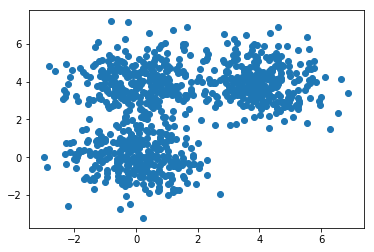

converged at iteration number 13
[ 4634.3429174   3630.59119841  3276.54842296  2578.2880917   1938.86590361
  1775.62588628  1765.55313224  1764.8319125   1764.76286101  1764.75224864
  1764.75006431  1764.74956905  1764.74945384  1764.74942686     0.             0.
     0.             0.             0.             0.        ]


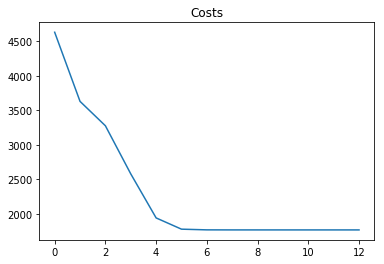

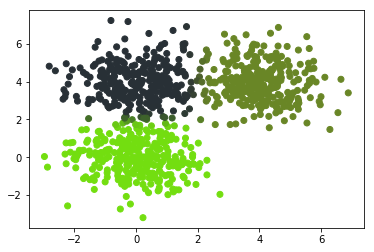

Did not converge
[ 3503.62655116  1583.09781823  1475.05477555  1480.20047578  1481.79948846
  1481.70544878  1481.19560309  1480.58478184  1479.97795721  1479.41923658
  1478.92290274  1478.48813155  1478.10753554  1477.77167886  1477.47121623
  1477.19776816  1476.94417166  1476.70444652  1476.47365021  1476.24770515
  1476.02323576  1475.79743012  1475.56792944  1475.33274431  1475.09019477
  1474.83887054  1474.5776084   1474.30548312  1474.02180872  1473.72614616]


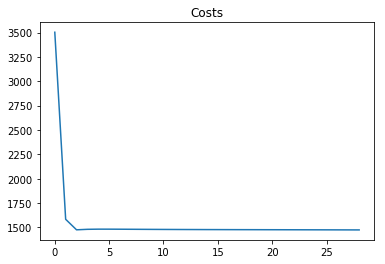

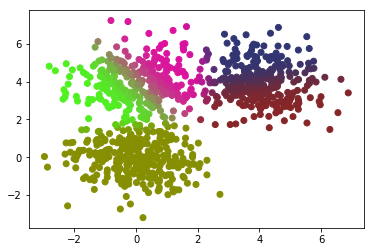

Did not converge
[ 3503.62655116  1583.09781823  1475.05477555  1480.20047578  1481.79948846
  1481.70544878  1481.19560309  1480.58478184  1479.97795721  1479.41923658
  1478.92290274  1478.48813155  1478.10753554  1477.77167886  1477.47121623
  1477.19776816  1476.94417166  1476.70444652  1476.47365021  1476.24770515
  1476.02323576  1475.79743012  1475.56792944  1475.33274431  1475.09019477
  1474.83887054  1474.5776084   1474.30548312  1474.02180872  1473.72614616]


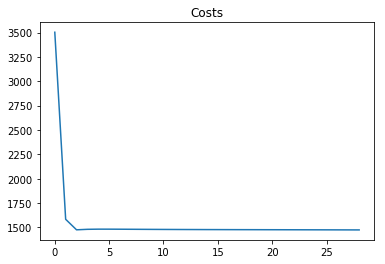

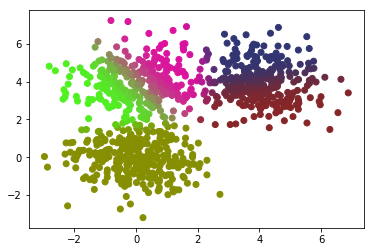

In [44]:
if __name__ == '__main__':
    main()
    